In [1]:
%matplotlib inline
import os, sys
from datetime import datetime
sys.path.append("../model/")
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
import keras
import tensorflow as tf

from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

from unet import UNET
from dilatedUnet import DILATEDUNET
from mobileunet import MOBILEUNET
from train_utils import *
from data_utils import *
from loss import *

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `flo

In [2]:
from data_utils import rotation_func, rescaling_func
from data_utils import flip_func, random_crop_func
from data_utils import random_noise_func, gamma_func, color_gamma_func

In [3]:
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

In [10]:
#model_name = "unet"
model_name = "unet"
h5_path = "../data/dataset.h5"

batch_size = 1
if batch_size == 1:
    instance = True
else:
    instance = False
    
nb_epoch = 200

img_dim = (256,256,3)
output_dim = (256,256,1)

#nb_filter = 16
nb_filter = 32
depth = 5
activation= 'LeakyReLU'
bn = True
lr = 0.0002
beta_1 = 0.5
#loss_function = bcf_dice_loss(0.5)
loss_function = 'binary_crossentropy'
sigmoid = True
drop_rate = 0.
bg_removal = False

dataset_ratio = 0.6

crop = True
crop_pad = 10
crop_keep_shape = False

title = "1th trial - Basis"
description = '''
'''

In [11]:
train_baidu = load_dataset(dataset_name='baidu_train',h5_path=h5_path)
train_crawl = load_dataset(dataset_name='crawl_train',h5_path=h5_path)

test_baidu  = load_dataset(dataset_name='baidu_test',h5_path=h5_path)
test_crawl  = load_dataset(dataset_name='crawl_test',h5_path=h5_path)

testset = np.concatenate([test_crawl])

epoch_size = int(len(train_baidu) +\
                 len(train_crawl))
train_steps = epoch_size // batch_size

In [12]:
generator = lambda dataset : HumanSegGenerator(dataset, img_dim,
                             batch_size=batch_size,
                             sigmoid=sigmoid,
                             bg_removal=bg_removal,
                             crop=crop,
                             crop_pad=crop_pad,
                             crop_keep_shape=crop_keep_shape,
                             aug_funcs=[rotation_func(min_angle=-10,max_angle=10),
                                       flip_func(),
                                       random_noise_func(),
                                       gamma_func(),
                                       color_gamma_func()],
                             prep_funcs=[])

def combined_genrator(dataset1,dataset2,ratio):
    gen1 = generator(dataset1)
    gen2 = generator(dataset2)
    while True:
        if np.random.random()>ratio:
            yield next(gen1)
        else:
            yield next(gen2)

In [13]:
traingen = combined_genrator(train_crawl,train_baidu,dataset_ratio)

test_images, test_profiles = next(HumanSegGenerator(testset,img_dim,
                                                    batch_size=len(testset),
                                                    sigmoid=sigmoid,
                                                    bg_removal=bg_removal,
                                                    crop=crop,
                                                    crop_pad=0,
                                                    crop_keep_shape=crop_keep_shape,
                                                    prep_funcs=[]))

In [16]:
# create the model
unet = DILATEDUNET(img_dim=img_dim,
            depth=depth,
            nb_filter=nb_filter,
            activation=activation,
            output_dim=output_dim,
            bn=bn,
            instance=instance,
            sigmoid=sigmoid,
            dilation_rate=2)
# unet = UNET(img_dim=img_dim,
#             depth=depth,
#             nb_filter=nb_filter,
#             activation=activation,
#             output_dim=output_dim,
#             bn=bn,
#             instance=instance,
#             sigmoid=sigmoid)

# unet = MOBILEUNET(img_dim=img_dim,
#             depth=depth,
#             nb_filter=nb_filter,
#             output_dim=output_dim,
#             bn=bn,
#             instance=instance,
#             sigmoid=sigmoid)

In [17]:
# set the model directory to save 
weights_dir, model_dir, sample_dir = set_directory("../results",model_name)

# plot the model arch image
model_path = os.path.join(model_dir, "unet.png")
plot_model(unet, to_file=model_path, show_shapes=True)

# serialize model to JSON
model_json = unet.to_json()
with open(os.path.join(model_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)

# set callback function
tqdm = TQDMNotebookCallback()
modelcheckpoint = ModelCheckpoint(os.path.join(weights_dir,
                                               "model_{val_mean_iou:.4f}.h5"),
                                  monitor='val_mean_iou',
                                  mode='max',
                                  save_weights_only=True,
                                  save_best_only=True,
                                  period=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              patience=10)
plotcheckpoint = PlotCheckpoint(unet,test_images, sample_dir)
callbacks= [tqdm, modelcheckpoint, earlystopping, plotcheckpoint]

# set loss and optimizer
unet.compile(Adam(lr=lr,beta_1=beta_1),
            loss=loss_function,
            metrics=[mean_iou])

HBox(children=(IntProgress(value=0, description='Training', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=3166), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=3166), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 3', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 4', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 5', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

HBox(children=(IntProgress(value=0, description='Epoch 9', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 10', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 11', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 12', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

HBox(children=(IntProgress(value=0, description='Epoch 17', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 18', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

HBox(children=(IntProgress(value=0, description='Epoch 23', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 24', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 25', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 26', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 27', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

HBox(children=(IntProgress(value=0, description='Epoch 30', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, description='Epoch 31', max=3166), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

HBox(children=(IntProgress(value=0, description='Epoch 35', max=3166), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=3166), HTML(value='')))


Saved model to disk


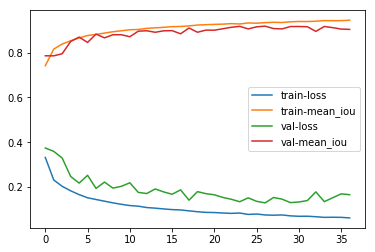

In [18]:
hist = unet.fit_generator(traingen,
                           train_steps,
                           epochs=nb_epoch,
                           verbose=0, 
                           validation_data = (test_images, test_profiles),
                           callbacks=callbacks)

# Draw the results
df = pd.DataFrame({"train-loss":hist.history['loss'],
                   "val-loss":hist.history['val_loss'],
                   "train-mean_iou":hist.history['mean_iou'],
                   "val-mean_iou":hist.history['val_mean_iou']})
df.to_csv(os.path.join(model_dir,"training.csv"))
df.plot().figure.savefig(os.path.join(model_dir,"training.png"))

# serialize weights to HDF5
unet.save_weights(os.path.join(weights_dir,"model.h5"))
print("Saved model to disk")

# Send to results
best_idx = df['val-mean_iou'].sort_values(ascending=False).index[0]
best_iou = df['val-mean_iou'].sort_values(ascending=False).iloc[0]

description = description \
+ "\nmodel_path : {}".format(weights_dir[:-7])\
+ "\nbest_mean_iou : {}".format(best_iou)

image_paths = {
    'model' : os.path.join(model_dir,"unet.png"),
    'train-process' : os.path.join(model_dir,'training.png'),
    'train-process-csv' : os.path.join(model_dir,"training.csv"),
    'test image' : os.path.join(sample_dir,
    "{:02d}_epoch_sample.png".format(best_idx))
}

[reference](http://openresearch.ai/t/mobilenets-efficient-convolutional-neural-networks-for-mobile-vision-applications/20)

In [ ]:
1